<a href="https://colab.research.google.com/github/aledelorbe/pt2Codigos/blob/main/SegundasActividades/Algoritmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cargar librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.cluster import KMeans

### Cargar los dataFrame

In [3]:
nuevaMortalidadLimpia = '/content/drive/MyDrive/Pt2/Primeras Actividades/0 Bases de Datos/Nueva Mortalidad Limpia/'

df2010 = pd.read_csv(nuevaMortalidadLimpia + '2010.csv')
df2011 = pd.read_csv(nuevaMortalidadLimpia + '2011.csv')
df2012 = pd.read_csv(nuevaMortalidadLimpia + '2012.csv')
df2013 = pd.read_csv(nuevaMortalidadLimpia + '2013.csv')
df2014 = pd.read_csv(nuevaMortalidadLimpia + '2014.csv')
df2015 = pd.read_csv(nuevaMortalidadLimpia + '2015.csv')
df2016 = pd.read_csv(nuevaMortalidadLimpia + '2016.csv')
df2017 = pd.read_csv(nuevaMortalidadLimpia + '2017.csv')
df2018 = pd.read_csv(nuevaMortalidadLimpia + '2018.csv')
df2019 = pd.read_csv(nuevaMortalidadLimpia + '2019.csv')

### Unir todos los fragmentos

In [4]:
dfDefinitivo = pd.concat([df2010, df2011, df2012, df2013, df2014, df2015, df2016, df2017, df2018, df2019], ignore_index=True)

### Determinacion de valores distintos en cada columna

In [5]:
# Definicion de la funcion que imprimira los valores distintos de determinada columna en orden alfabetico
def imprimirValoresDistintos(df20xx, nombreColumna):
  titulo = f"Columna {nombreColumna}".center(100, '-')
  valoresDistintos = list(df2010[nombreColumna].unique())
  valoresDistintos.sort()
  print(titulo)
  print(valoresDistintos)
  print(f'Cantidad de elementos: {len(valoresDistintos)}')

  return valoresDistintos

estados = imprimirValoresDistintos(dfDefinitivo, 'ent_resid_nm')
canceres = imprimirValoresDistintos(dfDefinitivo, 'Organ')
trabajos = imprimirValoresDistintos(dfDefinitivo, 'desc_ocupacion')

----------------------------------------Columna ent_resid_nm----------------------------------------
['Aguascalientes', 'Baja California', 'Baja California Sur', 'Campeche', 'Chiapas', 'Chihuahua', 'Coahuila de Zaragoza', 'Colima', 'Distrito Federal', 'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'Michoacán de Ocampo', 'Morelos', 'México', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo', 'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala', 'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas']
Cantidad de elementos: 32
-------------------------------------------Columna Organ--------------------------------------------
['Bladder', 'Bone', 'Brain', 'Breast', 'Cervix Uteri', 'Colon and Rectum', 'Esophagus', 'Eyes', 'Female Genitals', 'Gallbladder', 'Heart', "Hodgkin's Lymphoma", 'Kidney', 'Larynx', 'Leukemia', 'Liver ', 'Lungs', 'Lymphoma', 'Male Genitales', 'Melanoma', 'Mesothelioma', 'Mylenoma', 'Nervous', 'Oral Cavity an

In [6]:
# Para este caso se hace distinto ya que se desea crear una jerarquia (de menor a mayor jerarquia)
nivelesEscolares = [
    'No especificada ',
    'No aplica a menores de 3 años',
    'Sin escolaridad',
    'Preescolar',
    'Primaria completa',
    'Secundaria incompleta',
    'Secundaria completa',
    'Bachillerato o preparatoria',
    'Profesional',
    'Posgrado',
]
print(f'Cantidad de elementos: {len(nivelesEscolares)}')

Cantidad de elementos: 10


### Asociar variables y metricas por cada estado

In [7]:
# Para contar cuantas personas hay con cada tipo de cancer en cierto estado
# contemplando que puede haber 0 personas con cierto tipo de cancer en cierto estado
def contadorFrecuencias(df, estado, variable, catalogoX):
  result = None
  for elemento in catalogoX:
    condicionX = (df['ent_resid_nm'] == estado) & (df[variable] == elemento)
    resultAux = df[condicionX].groupby(variable).size().reset_index(name='Frecuencia')

    if len(resultAux) == 0:
      dfAux = pd.DataFrame({variable: [elemento], 'Frecuencia': [0]})
      result = pd.concat([result, resultAux, dfAux], ignore_index=True)
    else:
      result = pd.concat([result, resultAux], ignore_index=True)
  #print(result)

  return result

# Realizar una especie de transpuesta para pasar de tener filas asi: 'tipoCancer1', 'frecuencia1'; tipoCancer2', 'frecuencia2';
# tener columnas asi: 'tipoCancer1', 'frecuencia1', tipoCancer2', 'frecuencia2',
def transpuesta(df, variable):
  dfTranspuesta = pd.DataFrame({"vacio": [0]})
  for index, row in df.iterrows():
    dfTranspuesta[variable + str(index)] = row[variable]
    dfTranspuesta[variable + str(index) + 'Cant'] = row["Frecuencia"]
  dfTranspuesta = dfTranspuesta.drop(['vacio'], axis=1)
  #print(dfTranspuesta)

  return dfTranspuesta

# Para unir dos dataframe (uno a lado del otro).
def unirDataframes(df1, df2):
    # Crear columnas 'id' en ambos dataframes
    df1['id1'] = 1
    df2['id2'] = 1

    # Realizar union y eliminar las columnas 'id' de ambos dataframes
    df_union = pd.merge(df1, df2, left_on='id1', right_on='id2')
    df_union = df_union.drop(['id1', 'id2'], axis=1)

    return df_union

def asociador(estado, canceres, trabajos, nivelesEscolares):
  titulo = f"Estado {estado}".center(100, '-')
  print(titulo)

  dfEstadoX = pd.DataFrame({'estado': [estado]}) # 1

  # Asociar los tipos de canceres al estadoX. 36 x 2 = 72
  dfFrec = contadorFrecuencias(dfDefinitivo, estado, 'Organ', canceres)
  dfCancer = transpuesta(dfFrec, 'Organ')

  # Asociar los diferentes trabajos al estadoX. 13 x 2 = 26
  dfFrec = contadorFrecuencias(dfDefinitivo, estado, 'desc_ocupacion', trabajos)
  dfTrabajo = transpuesta(dfFrec, 'desc_ocupacion')

  # Asociar los diferentes niveles academicos al estadoX. 10 x 2 = 20
  dfFrec = contadorFrecuencias(dfDefinitivo, estado, 'desc_escolaridad', nivelesEscolares)
  dfEducacion = transpuesta(dfFrec, 'desc_escolaridad')

  # Unir todos estos dataframe (uno a lado del otro). Total 119
  dfEstadoX = unirDataframes(dfEstadoX, dfCancer)
  dfEstadoX = unirDataframes(dfEstadoX, dfTrabajo)
  dfEstadoX = unirDataframes(dfEstadoX, dfEducacion)

  print(dfEstadoX)
  print(dfEstadoX.to_string())
  return dfEstadoX


dfEstados = pd.DataFrame()

# Caso para todos
for estado in estados: # 4:27
  dfEstadoSingular = asociador(estado, canceres, trabajos, nivelesEscolares)
  dfEstados = pd.concat([dfEstados, dfEstadoSingular], ignore_index=True)

# Caso singular
#dfEstadoSingular = asociador('Aguascalientes', canceres, trabajos, nivelesEscolares)
#dfEstados = pd.concat([dfEstados, dfEstadoSingular], ignore_index=True)

---------------------------------------Estado Aguascalientes----------------------------------------
           estado   Organ0  Organ0Cant Organ1  Organ1Cant Organ2  Organ2Cant  \
0  Aguascalientes  Bladder         123   Bone         130  Brain         276   

   Organ3  Organ3Cant        Organ4  ...      desc_escolaridad5  \
0  Breast         710  Cervix Uteri  ...  Secundaria incompleta   

  desc_escolaridad5Cant    desc_escolaridad6 desc_escolaridad6Cant  \
0                   166  Secundaria completa                   993   

             desc_escolaridad7 desc_escolaridad7Cant  desc_escolaridad8  \
0  Bachillerato o preparatoria                   671        Profesional   

  desc_escolaridad8Cant  desc_escolaridad9 desc_escolaridad9Cant  
0                   902           Posgrado                    82  

[1 rows x 119 columns]
           estado   Organ0  Organ0Cant Organ1  Organ1Cant Organ2  Organ2Cant  Organ3  Organ3Cant        Organ4  Organ4Cant            Organ5  Organ5Cant 

### Transformaciones

#### Educación

In [8]:
# Definicion de la funcion que codificara a la variable 'desc_escolaridad'
def codificadorOrdinalEducacion(df20xx, nombreDf, educaciones):
  print(df20xx)

  # Crear cada elemento de 'educaciones' como una columna y rellenarla con puros 0's
  for elemento in educaciones:
    df20xx[elemento] = 0

  # Hacer que: si un registro tiene cierta categoria, todas las categorias de menor jerarquia a esa, se les coloque
  # un uno. Pe si un registro tiene la categoria primaria completa a esa columna colocarle un uno, pero tambien
  # en 'preescolar', en 'No aplica a menores de 3 años' y en 'No especificada ' ó si una persona tiene el valor de
  # posgrado tendra un uno en esa columna y en todas las demas (porque es el de mayor jerarquia).
  condicion1 = (df20xx['desc_escolaridad'] == 'No especificada ')
  df20xx.loc[condicion1, educaciones[0]] = 1

  condicion2 = (df20xx['desc_escolaridad'] == 'No aplica a menores de 3 años')
  df20xx.loc[condicion2, educaciones[0:2]] = 1

  condicion3 = (df20xx['desc_escolaridad'] == 'Sin escolaridad')
  df20xx.loc[condicion3, educaciones[0:3]] = 1

  condicion4 = (df20xx['desc_escolaridad'] == 'Preescolar')
  df20xx.loc[condicion4, educaciones[0:4]] = 1

  condicion5 = (df20xx['desc_escolaridad'] == 'Primaria completa')
  df20xx.loc[condicion5, educaciones[0:5]] = 1

  condicion6 = (df20xx['desc_escolaridad'] == 'Secundaria incompleta')
  df20xx.loc[condicion6, educaciones[0:6]] = 1

  condicion7 = (df20xx['desc_escolaridad'] == 'Secundaria completa')
  df20xx.loc[condicion7, educaciones[0:7]] = 1

  condicion8 = (df20xx['desc_escolaridad'] == 'Bachillerato o preparatoria')
  df20xx.loc[condicion8, educaciones[0:8]] = 1

  condicion9 = (df20xx['desc_escolaridad'] == 'Profesional')
  df20xx.loc[condicion9, educaciones[0:9]] = 1

  condicion10 = (df20xx['desc_escolaridad'] == 'Posgrado')
  df20xx.loc[condicion10, educaciones[0:10]] = 1

  # Imprimir resultado
  titulo = f"DataFrame {nombreDf}".center(100, '-')
  print(titulo)
  print(df20xx.to_string())

  return df20xx

# Crear df con los niveles escolares
dfEducacionSinCod = pd.DataFrame({'desc_escolaridad': nivelesEscolares})

# Mandar a llamar a la funcion dumizadora de la variable 'escolaridad'
dfEducacionCod = codificadorOrdinalEducacion(dfEducacionSinCod, 'Niveles escolares codificados', nivelesEscolares)

                desc_escolaridad
0               No especificada 
1  No aplica a menores de 3 años
2                Sin escolaridad
3                     Preescolar
4              Primaria completa
5          Secundaria incompleta
6            Secundaria completa
7    Bachillerato o preparatoria
8                    Profesional
9                       Posgrado
------------------------------DataFrame Niveles escolares codificados-------------------------------
                desc_escolaridad  No especificada   No aplica a menores de 3 años  Sin escolaridad  Preescolar  Primaria completa  Secundaria incompleta  Secundaria completa  Bachillerato o preparatoria  Profesional  Posgrado
0               No especificada                  1                              0                0           0                  0                      0                    0                            0            0         0
1  No aplica a menores de 3 años                 1                              1   

#### Educacion. Poner toda la matriz en una sola fila

In [9]:
# Definicion de la funcion que se encarga de poner todo el contenido de una matriz en una sola fila
def vectorizar(df, caso):
  columnas = df.columns.tolist()
  columnas = columnas[1:]
  #print(len(columnas))

  dfCodVect = pd.DataFrame({"vacio": [0]})
  for index, row in df.iterrows():
    if caso == 'Educacion':
      dfAux = pd.DataFrame({columnas[0] + str(index): [row[columnas[0]]],
                            columnas[1] + str(index): [row[columnas[1]]],
                            columnas[2] + str(index): [row[columnas[2]]],
                            columnas[3] + str(index): [row[columnas[3]]],
                            columnas[4] + str(index): [row[columnas[4]]],
                            columnas[5] + str(index): [row[columnas[5]]],
                            columnas[6] + str(index): [row[columnas[6]]],
                            columnas[7] + str(index): [row[columnas[7]]],
                            columnas[8] + str(index): [row[columnas[8]]],
                            columnas[9] + str(index): [row[columnas[9]]]})
      dfCodVect = pd.concat([dfCodVect, dfAux], axis=1) # 10r x 10col = 100
    elif caso == 'Empleo':
      dfAux = pd.DataFrame({columnas[0] + str(index): [row[columnas[0]]],
                            columnas[1] + str(index): [row[columnas[1]]],
                            columnas[2] + str(index): [row[columnas[2]]],
                            columnas[3] + str(index): [row[columnas[3]]],
                            columnas[4] + str(index): [row[columnas[4]]],
                            columnas[5] + str(index): [row[columnas[5]]],
                            columnas[6] + str(index): [row[columnas[6]]],
                            columnas[7] + str(index): [row[columnas[7]]],
                            columnas[8] + str(index): [row[columnas[8]]],
                            columnas[9] + str(index): [row[columnas[9]]],
                            columnas[10] + str(index): [row[columnas[10]]],
                            columnas[11] + str(index): [row[columnas[11]]]}) # Un elemento menos por la ausencia de una columna (por la redundancia)
      dfCodVect = pd.concat([dfCodVect, dfAux], axis=1) # 13r x 12col = 156
    elif caso == 'Cancer':
      dfAux = pd.DataFrame({columnas[0] + str(index): [row[columnas[0]]],
                            columnas[1] + str(index): [row[columnas[1]]],
                            columnas[2] + str(index): [row[columnas[2]]],
                            columnas[3] + str(index): [row[columnas[3]]],
                            columnas[4] + str(index): [row[columnas[4]]],
                            columnas[5] + str(index): [row[columnas[5]]],
                            columnas[6] + str(index): [row[columnas[6]]],
                            columnas[7] + str(index): [row[columnas[7]]],
                            columnas[8] + str(index): [row[columnas[8]]],
                            columnas[9] + str(index): [row[columnas[9]]],
                            columnas[10] + str(index): [row[columnas[10]]],
                            columnas[11] + str(index): [row[columnas[11]]],
                            columnas[12] + str(index): [row[columnas[12]]],
                            columnas[13] + str(index): [row[columnas[13]]],
                            columnas[14] + str(index): [row[columnas[14]]],
                            columnas[15] + str(index): [row[columnas[15]]],
                            columnas[16] + str(index): [row[columnas[16]]],
                            columnas[17] + str(index): [row[columnas[17]]],
                            columnas[18] + str(index): [row[columnas[18]]],
                            columnas[19] + str(index): [row[columnas[19]]],
                            columnas[20] + str(index): [row[columnas[20]]],
                            columnas[21] + str(index): [row[columnas[21]]],
                            columnas[22] + str(index): [row[columnas[22]]],
                            columnas[23] + str(index): [row[columnas[23]]],
                            columnas[24] + str(index): [row[columnas[24]]],
                            columnas[25] + str(index): [row[columnas[25]]],
                            columnas[26] + str(index): [row[columnas[26]]],
                            columnas[27] + str(index): [row[columnas[27]]],
                            columnas[28] + str(index): [row[columnas[28]]],
                            columnas[29] + str(index): [row[columnas[29]]],
                            columnas[30] + str(index): [row[columnas[30]]],
                            columnas[31] + str(index): [row[columnas[31]]],
                            columnas[32] + str(index): [row[columnas[32]]],
                            columnas[33] + str(index): [row[columnas[33]]],
                            columnas[34] + str(index): [row[columnas[34]]]}) # Un elemento menos por la ausencia de una columna (por la redundancia)
      dfCodVect = pd.concat([dfCodVect, dfAux], axis=1) # 36r x 35col = 1260

  dfCodVect = dfCodVect.drop(['vacio'], axis=1)
  print(dfCodVect)
  print(dfCodVect.to_string())

  return dfCodVect

# Mandar a llamar la funcion vectorizar para aplicarla sobre el df de: 'Educacion'
dfEducacionCodVect = vectorizar(dfEducacionCod, 'Educacion')

   No especificada 0  No aplica a menores de 3 años0  Sin escolaridad0  \
0                  1                               0                 0   

   Preescolar0  Primaria completa0  Secundaria incompleta0  \
0            0                   0                       0   

   Secundaria completa0  Bachillerato o preparatoria0  Profesional0  \
0                     0                             0             0   

   Posgrado0  ...  No especificada 9  No aplica a menores de 3 años9  \
0          0  ...                  1                               1   

   Sin escolaridad9  Preescolar9  Primaria completa9  Secundaria incompleta9  \
0                 1            1                   1                       1   

   Secundaria completa9  Bachillerato o preparatoria9  Profesional9  Posgrado9  
0                     1                             1             1          1  

[1 rows x 100 columns]
   No especificada 0  No aplica a menores de 3 años0  Sin escolaridad0  Preescolar0  Primar

#### Empleo

In [10]:
# Definicion de la funcion que dumizara distintas variables en cada fragmento
def duminizador(df20xx, nombreDf, nombreVariable):
  print(df20xx)

  # Dumizar variable
  dummies = pd.get_dummies(df20xx[nombreVariable], drop_first = True)
  # drop_first = True -> es para que nos agregue solo k-1 categorias distintas y no se agregue la categoria k la cual solo provoca redundancia
  df20xx = pd.concat([df20xx, dummies], axis = 1) # Añadimos las variables binarias al DataFrame

  # Solicitud de las categorias que se encuentran en la variable: 'desc_ocupacion'
  nombresCategoriasX = dummies.columns.tolist()

  # Imprimir resultado
  titulo = f"DataFrame {nombreDf}".center(100, '-')
  print(titulo)
  print(df20xx.to_string())

  return df20xx

# Crear df con los tipos de trabajo
dfTrabajosSinCod = pd.DataFrame({'desc_ocupacion': trabajos})

# Mandar a llamar a la funcion dumizadora de la variable 'trabajos'
dfTrabajosCod = duminizador(dfTrabajosSinCod, 'Trabajos codificados', 'desc_ocupacion')

                                       desc_ocupacion
0   Comerciantes, empleados en ventas y agentes de...
1                    Funcionarios, directores y jefes
2                      Insuficientemente especificada
3                       No aplica a menores de 5 años
4                                     No especificada
5                                          No trabaja
6   Operadores de maquinaria industrial, ensamblad...
7                           Profesionistas y técnicos
8                            Trabajadores artesanales
9   Trabajadores auxiliares en actividades adminis...
10  Trabajadores en actividades agrícolas, ganader...
11  Trabajadores en actividades elementales y de a...
12  Trabajadores en servicios personales y vigilancia
-----------------------------------DataFrame Trabajos codificados-----------------------------------
                                                                              desc_ocupacion  Funcionarios, directores y jefes  Insuficientemen

#### Empleo. Poner toda la matriz en una sola fila

In [11]:
# Mandar a llamar la funcion vectorizar para aplicarla sobre el df de: 'Empleo'
dfTrabajosCodVect = vectorizar(dfTrabajosCod, 'Empleo')

   Funcionarios, directores y jefes0  Insuficientemente especificada0  \
0                                  0                                0   

   No aplica a menores de 5 años0  No especificada0  No trabaja0  \
0                               0                 0            0   

   Operadores de maquinaria industrial, ensambladores, choferes y conductores de transporte0  \
0                                                  0                                           

   Profesionistas y técnicos0  Trabajadores artesanales0  \
0                           0                          0   

   Trabajadores auxiliares en actividades administrativas0  \
0                                                  0         

   Trabajadores en actividades agrícolas, ganaderas, forestales, caza y pesca0  \
0                                                  0                             

   ...  No aplica a menores de 5 años12  No especificada12  No trabaja12  \
0  ...                              

#### Cancer

In [12]:
# Crear df con los tipos de cancer
dfCanceresSinCod = pd.DataFrame({'Organ': canceres})

# Mandar a llamar a la funcion dumizadora de la variable 'trabajos'
dfCanceresCod = duminizador(dfCanceresSinCod, 'Canceres codificados', 'Organ')

                      Organ
0                   Bladder
1                      Bone
2                     Brain
3                    Breast
4              Cervix Uteri
5          Colon and Rectum
6                 Esophagus
7                      Eyes
8           Female Genitals
9               Gallbladder
10                    Heart
11       Hodgkin's Lymphoma
12                   Kidney
13                   Larynx
14                 Leukemia
15                   Liver 
16                    Lungs
17                 Lymphoma
18           Male Genitales
19                 Melanoma
20             Mesothelioma
21                 Mylenoma
22                  Nervous
23  Oral Cavity and Pharynx
24       Outter Respiratory
25                    Ovary
26                 Pancreas
27                 Prostate
28       Skin non Melanoma 
29              Soft Tissue
30                  Stomach
31                   Testis
32                  Thyroid
33                  Trachea
34                  

#### Cancer. Poner toda la matriz en una sola fila

In [13]:
# Mandar a llamar la funcion vectorizar para aplicarla sobre el df de: 'Cancer'
dfCanceresCodVect = vectorizar(dfCanceresCod, 'Cancer')

   Bone0  Brain0  Breast0  Cervix Uteri0  Colon and Rectum0  Esophagus0  \
0      0       0        0              0                  0           0   

   Eyes0  Female Genitals0  Gallbladder0  Heart0  ...  Pancreas35  Prostate35  \
0      0                 0             0       0  ...           0           0   

   Skin non Melanoma 35  Soft Tissue35  Stomach35  Testis35  Thyroid35  \
0                     0              0          0         0          0   

   Trachea35  Ureter35  Urinary Tract Other35  
0          0         0                      1  

[1 rows x 1260 columns]
   Bone0  Brain0  Breast0  Cervix Uteri0  Colon and Rectum0  Esophagus0  Eyes0  Female Genitals0  Gallbladder0  Heart0  Hodgkin's Lymphoma0  Kidney0  Larynx0  Leukemia0  Liver 0  Lungs0  Lymphoma0  Male Genitales0  Melanoma0  Mesothelioma0  Mylenoma0  Nervous0  Oral Cavity and Pharynx0  Outter Respiratory0  Ovary0  Pancreas0  Prostate0  Skin non Melanoma 0  Soft Tissue0  Stomach0  Testis0  Thyroid0  Trachea0  Ure

#### Entidad Federativa

In [14]:
# Crear df con los tipos de cancer
dfEstadosSinCod = pd.DataFrame({'ent_resid_nm': estados})

# Mandar a llamar a la funcion dumizadora de la variable 'trabajos'
dfEstadosCod = duminizador(dfEstadosSinCod, 'Estados codificados', 'ent_resid_nm')

                       ent_resid_nm
0                    Aguascalientes
1                   Baja California
2               Baja California Sur
3                          Campeche
4                           Chiapas
5                         Chihuahua
6              Coahuila de Zaragoza
7                            Colima
8                  Distrito Federal
9                           Durango
10                       Guanajuato
11                         Guerrero
12                          Hidalgo
13                          Jalisco
14              Michoacán de Ocampo
15                          Morelos
16                           México
17                          Nayarit
18                       Nuevo León
19                           Oaxaca
20                           Puebla
21                        Querétaro
22                     Quintana Roo
23                  San Luis Potosí
24                          Sinaloa
25                           Sonora
26                          

#### Aplicar transformaciones

##### Estados - Canceres

In [15]:
# Crear el df que almacenara todos los datos de estados-canceres
dfEstadosCanceres = pd.DataFrame()

for j in range(0, 32):
  # Extraer las transformaciones de un estado
  dfEstadoCancer = dfEstadosCod.iloc[j:j + 1, 1:]

  # Un solo estadoCancer (una sola fila) debe tener: 31 cols de estados + 1260 cols de cancer vect + 36 cols de 'OrganNCant' =  1327 cols
  for i in range(0, 36):
    df1 = dfEstadoCancer
    df2 = dfCanceresCodVect.iloc[0:1, 0 + (35*i):35 + (35*i)]
    df3 = dfEstados.iloc[j:j + 1, i*2 + 2]

    # De esta forma una fila queda con los siguientes datos: estado + tipoCancer1 + cantCancer1 + tipoCancer2 + cantCancer2 + ... y asi sucesivamente
    dfEstadoCancer = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True), df3.reset_index(drop=True)], axis=1)

  # Juntar un nuevo estadoCancer con todos los estadosCanceres (agregar la nueva fila al df mas gral.)
  dfEstadosCanceres = pd.concat([dfEstadosCanceres, dfEstadoCancer], ignore_index=True)

# Imprimir el resultado final
print('dfEstadosCanceres')
print(dfEstadosCanceres)
print(dfEstadosCanceres.to_string())

dfEstadosCanceres
    Baja California  Baja California Sur  Campeche  Chiapas  Chihuahua  \
0                 0                    0         0        0          0   
1                 1                    0         0        0          0   
2                 0                    1         0        0          0   
3                 0                    0         1        0          0   
4                 0                    0         0        1          0   
5                 0                    0         0        0          1   
6                 0                    0         0        0          0   
7                 0                    0         0        0          0   
8                 0                    0         0        0          0   
9                 0                    0         0        0          0   
10                0                    0         0        0          0   
11                0                    0         0        0          0   
12                0 

##### Estados - Empleos

In [16]:
# Crear el df que almacenara todos los datos de estados-trabajos
dfEstadosEmpleos = pd.DataFrame()

for j in range(0, 32):
  # Extraer las transformaciones de un estado
  dfEstadoEmpleo = dfEstadosCod.iloc[j:j + 1, 1:]

  # Un solo estadoEmpleo (una sola fila) debe tener: 31 cols de estados + 156 cols de cancer vect + 13 cols de 'desc_ocupacionNCant' =  200 cols
  for i in range(0, 13):
    df1 = dfEstadoEmpleo
    df2 = dfTrabajosCodVect.iloc[0:1, 0 + (12*i):12 + (12*i)]
    df3 = dfEstados.iloc[j:j + 1, i*2 + 74]

    # De esta forma una fila queda con los siguientes datos: estado + tipoEmpleo1 + cantEmpleo1 + tipoEmpleo2 + cantEmpleo2 + ... y asi sucesivamente
    dfEstadoEmpleo = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True), df3.reset_index(drop=True)], axis=1)

  # Juntar un nuevo estadoEmpleo con todos los estadosEmpleos (agregar la nueva fila al df mas gral.)
  dfEstadosEmpleos = pd.concat([dfEstadosEmpleos, dfEstadoEmpleo], ignore_index=True)

# Imprimir el resultado final
print('dfEstadosEmpleos')
print(dfEstadosEmpleos)
print(dfEstadosEmpleos.to_string())

dfEstadosEmpleos
    Baja California  Baja California Sur  Campeche  Chiapas  Chihuahua  \
0                 0                    0         0        0          0   
1                 1                    0         0        0          0   
2                 0                    1         0        0          0   
3                 0                    0         1        0          0   
4                 0                    0         0        1          0   
5                 0                    0         0        0          1   
6                 0                    0         0        0          0   
7                 0                    0         0        0          0   
8                 0                    0         0        0          0   
9                 0                    0         0        0          0   
10                0                    0         0        0          0   
11                0                    0         0        0          0   
12                0  

##### Estados - Niveles Educativos

In [17]:
# Crear el df que almacenara todos los datos de estados-Educaciones
dfEstadosEducaciones = pd.DataFrame()

for j in range(0, 32):
  # Extraer las transformaciones de un estado
  dfEstadoEducacion = dfEstadosCod.iloc[j:j + 1, 1:]

  # Un solo estadoEducacion (una sola fila) debe tener: 31 cols de estados + 100 cols de cancer vect + 10 cols de 'desc_escolaridadNCant' =  141 cols
  for i in range(0, 10):
    df1 = dfEstadoEducacion
    df2 = dfEducacionCodVect.iloc[0:1, 0 + (10*i):10 + (10*i)]
    df3 = dfEstados.iloc[j:j + 1, i*2 + 100]

    # De esta forma una fila queda con los siguientes datos: estado + tipoEducacion1 + cantEducacion1 + tipoEducacion2 + cantEducacion2 + ... y asi sucesivamente
    dfEstadoEducacion = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True), df3.reset_index(drop=True)], axis=1)

  # Juntar un nuevo estadoEducacion con todos los estadosEducaciones (agregar la nueva fila al df mas gral.)
  dfEstadosEducaciones = pd.concat([dfEstadosEducaciones, dfEstadoEducacion], ignore_index=True)

# Imprimir el resultado final
print('dfEstadosEducaciones')
print(dfEstadosEducaciones)
print(dfEstadosEducaciones.to_string())

dfEstadosEducaciones
    Baja California  Baja California Sur  Campeche  Chiapas  Chihuahua  \
0                 0                    0         0        0          0   
1                 1                    0         0        0          0   
2                 0                    1         0        0          0   
3                 0                    0         1        0          0   
4                 0                    0         0        1          0   
5                 0                    0         0        0          1   
6                 0                    0         0        0          0   
7                 0                    0         0        0          0   
8                 0                    0         0        0          0   
9                 0                    0         0        0          0   
10                0                    0         0        0          0   
11                0                    0         0        0          0   
12               

### Escalado de Datos

In [67]:
from sklearn.preprocessing import StandardScaler

# Definicion de la funcion que realiza el escalado de datos
def escalador(df, nombreDf):
  titulo = f"Dataframe {nombreDf}".center(100, '-')
  print(titulo)
  titulo2 = f"Antes del escalado".ljust(50, '-')
  print(titulo2)
  print(df.to_string())

  columnas = df.columns.tolist() # Determinar el nombre de las col's
  estadoVariableEscalador = StandardScaler()
  df = estadoVariableEscalador.fit_transform(df) # Escala los datos
  df = pd.DataFrame(df, columns=columnas) # Esto devolvera un numpy por eso se castea a df conservando el
  # nombre de las col's

  titulo3 = f"Despues del escalado".ljust(50, '-')
  print(titulo3)
  print(df.to_string())

  return df

# Definicion de la funcion que se encargara de
def escaladorDatos(df, caso, nombreDf):
  # Recopilar las columnas que se necesitan normalizar y almacenarlas en 'dfAnormal'
  dfAnormal = pd.DataFrame()

  if caso == 'Cancer':
    for i in range(0, 36):
      nombreColumna = df.columns[66 + (36*i)]  #Como hay 36 cols de 'OrganNCant' cada 36 cols habra
      dfAnormal[nombreColumna] = df.iloc[:, 66 + (36*i)] # coincidencia a partir de la 1er coicidencia

  elif caso == 'Empleo':
    for i in range(0, 13):
      nombreColumna = df.columns[43 + (13*i)]  #Como hay 13 cols de 'desc_ocupacionNCant' cada 13 cols habra
      dfAnormal[nombreColumna] = df.iloc[:, 43 + (13*i)] # coincidencia a partir de la 1er coicidencia

  elif caso == 'Educacion':
    for i in range(0, 10):
      nombreColumna = df.columns[41 + (11*i)]  #Como hay 10 cols de 'desc_escolaridadNCant' cada 10 cols habra
      dfAnormal[nombreColumna] = df.iloc[:, 41 + (11*i)] # coincidencia a partir de la 1er coicidencia

  # Mandar a llamar la funcion que Escala Datos
  dfNormal = escalador(dfAnormal, nombreDf)

  # Reemplazar los nuevos datos escalados en los df originales
  columnas = dfNormal.columns.to_list()

  for i in range(0, len(columnas)):
    df[columnas[i]] = dfNormal.iloc[:, i]

  titulo = f"DataFrame".ljust(50, '-')
  print(titulo)
  print(df.to_string())

  return df

#### Estados - Canceres

In [65]:
# Mandar a llamar la funcion que escalara los datos sobre el df: 'dfEstadosCanceres'
dfEstadosCanceres = escaladorDatos(dfEstadosCanceres, 'Cancer', 'Estados Canceres')

-------------------------------------Dataframe Estados Canceres-------------------------------------
Antes del escalado--------------------------------
    Organ0Cant  Organ1Cant  Organ2Cant  Organ3Cant  Organ4Cant  Organ5Cant  Organ6Cant  Organ7Cant  Organ8Cant  Organ9Cant  Organ10Cant  Organ11Cant  Organ12Cant  Organ13Cant  Organ14Cant  Organ15Cant  Organ16Cant  Organ17Cant  Organ18Cant  Organ19Cant  Organ20Cant  Organ21Cant  Organ22Cant  Organ23Cant  Organ24Cant  Organ25Cant  Organ26Cant  Organ27Cant  Organ28Cant  Organ29Cant  Organ30Cant  Organ31Cant  Organ32Cant  Organ33Cant  Organ34Cant  Organ35Cant
0    -0.692906   -0.819593   -0.708800   -0.693992   -0.880493   -0.767676   -0.884746   -0.880546   -0.844141   -0.741019    -0.504956    -0.784095    -0.775133    -1.093038    -0.797351    -0.891023    -0.770488    -0.742383    -1.002744    -0.596044    -0.397276    -0.732840    -0.744098    -0.905831    -0.791738    -0.691479    -0.814384    -0.840197    -0.893852    -0.656053    -

#### Estados - Empleos

In [68]:
# Mandar a llamar la funcion que escalara los datos sobre el df: 'dfEstadosEmpleos'
dfEstadosEmpleos = escaladorDatos(dfEstadosEmpleos, 'Empleo', 'Estados Empleos')

-------------------------------------Dataframe Estados Empleos--------------------------------------
Antes del escalado--------------------------------
    desc_ocupacion0Cant  desc_ocupacion1Cant  desc_ocupacion2Cant  desc_ocupacion3Cant  desc_ocupacion4Cant  desc_ocupacion5Cant  desc_ocupacion6Cant  desc_ocupacion7Cant  desc_ocupacion8Cant  desc_ocupacion9Cant  desc_ocupacion10Cant  desc_ocupacion11Cant  desc_ocupacion12Cant
0                   457                   43                  303                   78                   68                 4468                  287                  551                  333                  189                   541                   219                   106
1                  1164                  166                 1302                  164                  971                12440                 1010                 1606                  862                  602                   577                   483                   484
2          

#### Estados - Niveles Educativos

In [69]:
# Mandar a llamar la funcion que escalara los datos sobre el df: 'dfEstadosEducaciones'
dfEstadosEducaciones = escaladorDatos(dfEstadosEducaciones, 'Educacion', 'Estados Educaciones')

-----------------------------------Dataframe Estados Educaciones------------------------------------
Antes del escalado--------------------------------
    desc_escolaridad0Cant  desc_escolaridad1Cant  desc_escolaridad2Cant  desc_escolaridad3Cant  desc_escolaridad4Cant  desc_escolaridad5Cant  desc_escolaridad6Cant  desc_escolaridad7Cant  desc_escolaridad8Cant  desc_escolaridad9Cant
0                     247                     39                    767                   1835                   1942                    166                    993                    671                    902                     82
1                    1554                     85                   1795                   4083                   5382                    805                   3349                   2104                   2551                    125
2                     199                     15                    444                    988                   1135                    130         

### Algoritmos/Modelos

In [70]:
from sklearn.cluster import KMeans

In [75]:
def metodoCodo(df):
  X = df
  wcss = []
  cantidadClusters = 15
  for i in range(1, cantidadClusters):
      algoritmoKmeans = KMeans(n_clusters = i, n_init=10, init = 'k-means++', max_iter = 100, random_state = 0)
      algoritmoKmeans.fit(X)
      wcss.append(algoritmoKmeans.inertia_)

  plt.figure(figsize=(10, 6))
  plt.title('Metodo del codo')
  plt.plot(range(1, cantidadClusters), wcss)
  plt.scatter(range(1, cantidadClusters), wcss, s = 20)
  plt.xticks(range(1, cantidadClusters), range(1, cantidadClusters))
  plt.ylabel('WCSS')
  plt.xlabel('Numero de clusters')
  plt.grid()
  plt.show()

#### Primer Modelo

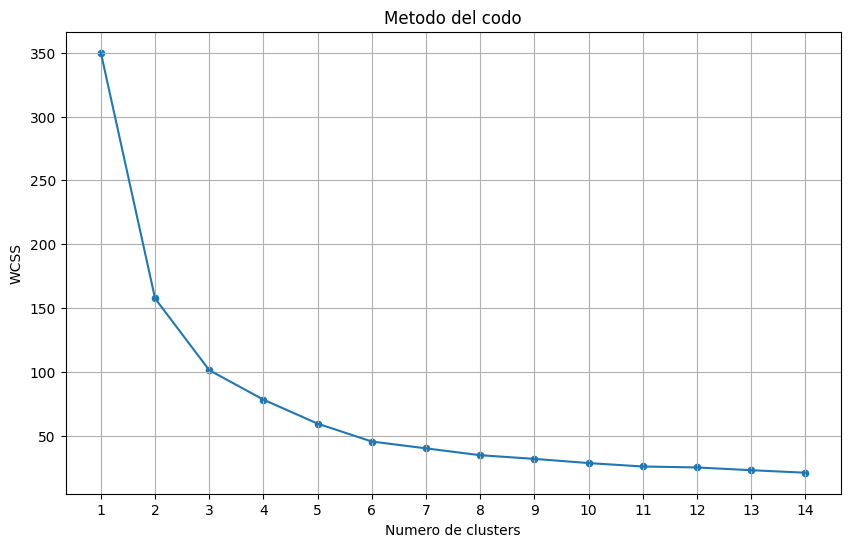

In [76]:
metodoCodo(dfEstadosEducaciones)


#### Segundo Modelo

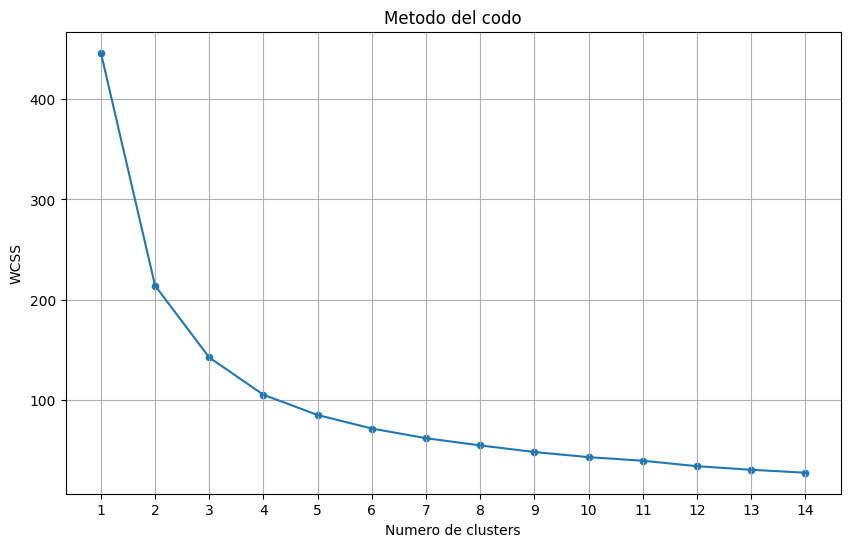

In [77]:
metodoCodo(dfEstadosEmpleos)

#### Tercer Modelo

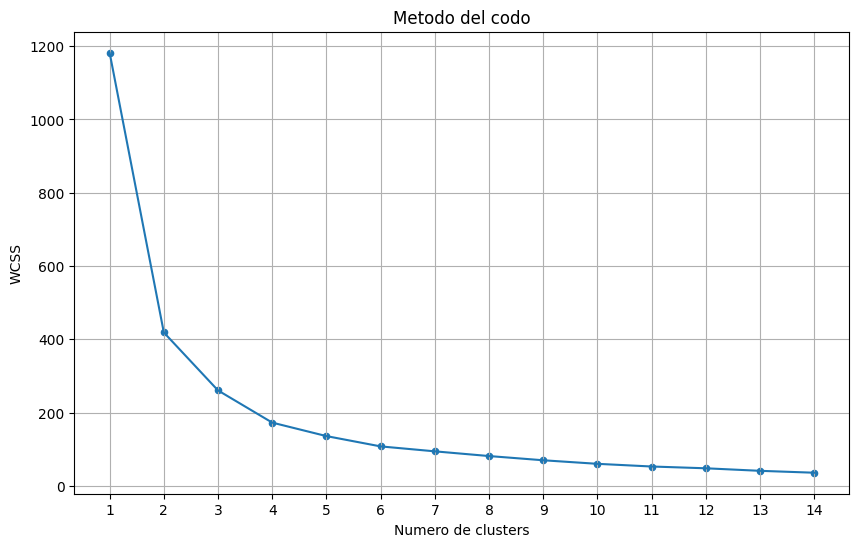

In [78]:
metodoCodo(dfEstadosCanceres)